In [1]:
import cv2
import numpy as np
from sklearn.preprocessing import normalize
from IPython import display
import pandas as pd
from pyntcloud import PyntCloud
from PIL import Image

filename = "screenshot"

leftPath = '/Volumes/Samir2T/kitti/2011_10_03/2011_10_03_drive_0027_sync/image_02/data/0000000419.png'
rightPath = '/Volumes/Samir2T/kitti/2011_10_03/2011_10_03_drive_0027_sync/image_03/data/0000000419.png'

img_left  = cv2.imread(leftPath)
img_right = cv2.imread(rightPath)

window_size = 1

left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*2,
    blockSize=5,
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    # disp12MaxDiff=1,
    # uniquenessRatio=15,
    # speckleWindowSize=0,
    # speckleRange=2,
    # preFilterCap=63,
    # mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*3,
    blockSize=5
)


right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(80000)
wls_filter.setSigmaColor(1.2)

disparity_left  = left_matcher.compute(img_left, img_right)
disparity_right = right_matcher.compute(img_right, img_left)
disparity_left  = np.int16(disparity_left)
disparity_right = np.int16(disparity_right)
filteredImg     = wls_filter.filter(disparity_left, img_left, None, disparity_right)

depth_map = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
depth_map = np.uint8(depth_map)
#depth_map = cv2.bitwise_not(depth_map) # Invert image. Optional depending on stereo pair
cv2.imwrite("depth.png",depth_map)

True

In [2]:
pil_im = Image.open("depth.png", 'r')

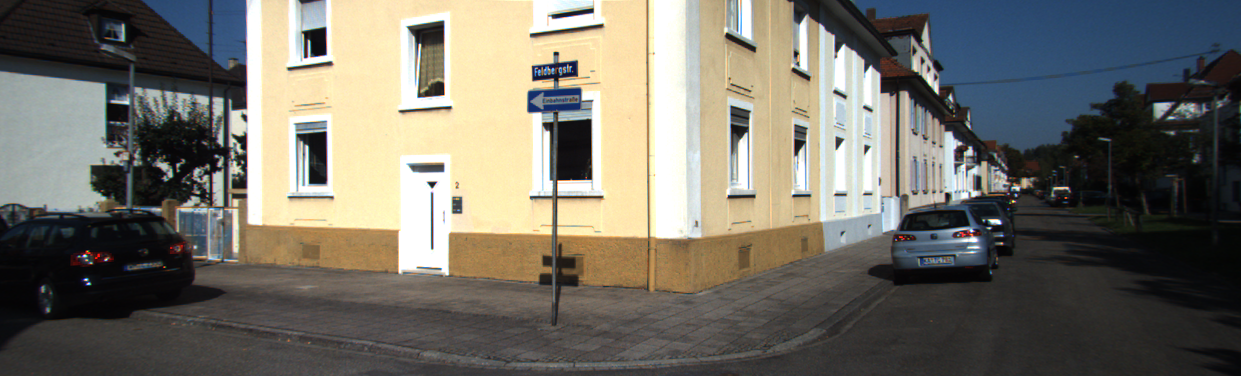

In [3]:
Image.open(leftPath)

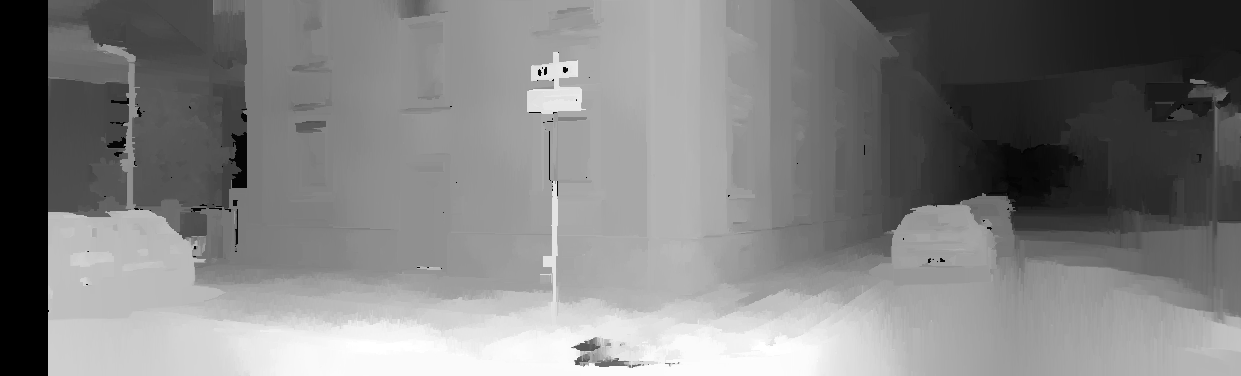

In [4]:
pil_im

In [5]:
focalLength = 525.0
centerX = 1#319.5
centerY = 1#239.5
scalingFactor = 1#5000.0

def generate_pointcloud(rgb_file,depth_file,ply_file):
    """
    Generate a colored point cloud in PLY format from a color and a depth image.
    
    Input:
    rgb_file -- filename of color image
    depth_file -- filename of depth image
    ply_file -- filename of ply file
    
    """
    rgb = Image.open(rgb_file)
    depth = Image.open(depth_file).convert("I")
    
    if rgb.size != depth.size:
        raise Exception("Color and depth image do not have the same resolution.")
    if rgb.mode != "RGB":
        raise Exception("Color image is not in RGB format")
    if depth.mode != "I":
        raise Exception("Depth image is not in intensity format")


    points = []    
    for v in range(rgb.size[1]):
        for u in range(rgb.size[0]):
            color = rgb.getpixel((u,v))
            Z = depth.getpixel((u,v)) / scalingFactor
            if Z==0: continue
            X = (u - centerX) * Z / focalLength
            Y = (v - centerY) * Z / focalLength
            points.append("%f %f %f %d %d %d 0\n"%(X,Y,Z,color[0],color[1],color[2]))
    file = open(ply_file,"w")
    file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
property uchar alpha
end_header
%s
'''%(len(points),"".join(points)))
    file.close()

In [9]:
ply_file = 'pdf.ply' 
generate_pointcloud(leftPath, 'depth.png', ply_file)
cloud = PyntCloud.from_file(ply_file)
cloud.plot(return_scene=True)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(149.9666748046875, 234.5444564819336, 516.11…

Preview(child=Scene(children=(Points(geometry=BufferGeometry(attributes={'position': <BufferAttribute shape=(4…

In [7]:


colourImg    = Image.open(leftPath)
colourPixels = colourImg.convert("RGB")

colourArray  = np.array(colourPixels.getdata()).reshape((colourImg.height, colourImg.width) + (3,))
indicesArray = np.moveaxis(np.indices((colourImg.height, colourImg.width)), 0, 2)
imageArray   = np.dstack((indicesArray, colourArray)).reshape((-1,5))
df = pd.DataFrame(imageArray, columns=["x", "y", "red","green","blue"])

depthImg = Image.open('depth.png').convert('L')
depthArray = np.array(depthImg.getdata())
df.insert(loc=2, column='z', value=depthArray)


df[['x','y','z']] = df[['x','y','z']].astype(float)
df[['red','green','blue']] = df[['red','green','blue']].astype(np.uint)


In [8]:
cloud = PyntCloud(df)
cloud.add_scalar_field("hsv")
cloud.plot(return_scene=True)

/Users/samirantonio/anaconda/envs/python3/lib/python3.6/site-packages/pyntcloud/scalar_fields/rgb.py:44: RuntimeWarning: invalid value encountered in true_divide
  H[idx] = 60 * (rgb[idx, 1] - rgb[idx, 2]) / MAX_MIN[idx]
/Users/samirantonio/anaconda/envs/python3/lib/python3.6/site-packages/pyntcloud/scalar_fields/rgb.py:48: RuntimeWarning: invalid value encountered in true_divide
  H[idx] = (60 * (rgb[idx, 2] - rgb[idx, 0]) / MAX_MIN[idx]) + 120
/Users/samirantonio/anaconda/envs/python3/lib/python3.6/site-packages/pyntcloud/scalar_fields/rgb.py:51: RuntimeWarning: invalid value encountered in true_divide
  H[idx] = (60 * (rgb[idx, 0] - rgb[idx, 1]) / MAX_MIN[idx]) + 240
/Users/samirantonio/anaconda/envs/python3/lib/python3.6/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(187.5, 1860.0, 510.9441917979666), quaternio…

Preview(child=Scene(children=(Points(geometry=BufferGeometry(attributes={'position': <BufferAttribute shape=(4…